In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train = pd.read_csv('../input/house-prices/train.csv') 
test = pd.read_csv('../input/house-prices/test.csv')

#Drop 'Street' column

/kaggle/input/house-prices/sample_submission.csv
/kaggle/input/house-prices/data_description.txt
/kaggle/input/house-prices/train.csv
/kaggle/input/house-prices/test.csv


In [2]:
import matplotlib.pyplot as plt

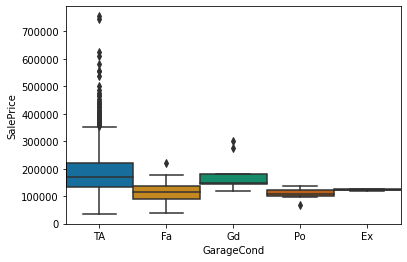

In [3]:
import seaborn as sns

sboxplot = sns.boxplot(y=train['SalePrice'], x=train['GarageCond'], width = 1,
                 palette="colorblind")



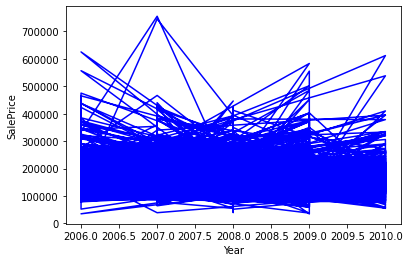

In [4]:
plt.plot(train['YrSold'], train['SalePrice'], color='blue')
plt.xlabel("Year")
plt.ylabel("SalePrice")

plt.show()

<AxesSubplot:xlabel='LotArea'>

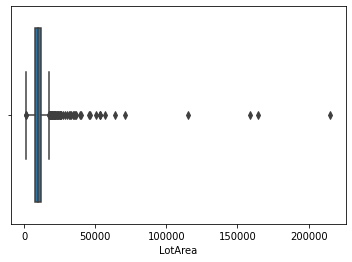

In [5]:
sns.boxplot(x=train['LotArea'])

Since feature 'LotArea' includes outliers, I may use Random Forest model. 

# **Feature Engineering**

In [6]:
#Calculate the expected number of 'good quality' basement bedrooms

#1. Classify 'Basement Quality' in indexes

def ClassifyBasementQuality() : 
    
    quality_mapping = {"GLQ" : 10, "ALQ" : 9, "BLQ" : 7, "Rec" : 6, "LwQ" : 4, "Unf": 2, "NA": 1} 
    
    train['BsmtFinType1'] = train['BsmtFinType1'].map(quality_mapping) 
    train['BsmtFinType2'] = train['BsmtFinType2'].map(quality_mapping)
    
    test['BsmtFinType1'] = test['BsmtFinType1'].map(quality_mapping) 
    test['BsmtFinType2'] = test['BsmtFinType2'].map(quality_mapping)
    
    
ClassifyBasementQuality()

df_basement = train['BsmtFinType1']

print(df_basement)

0       10.0
1        9.0
2       10.0
3        9.0
4       10.0
        ... 
1455     2.0
1456     9.0
1457    10.0
1458    10.0
1459     7.0
Name: BsmtFinType1, Length: 1460, dtype: float64


In [7]:
#Quality-Quantity Analysis - Higher Quality compensates for lower Quantity, Higher Quantity compensates for lower Quality in terms of price
#1. Quality Indexed : Ex : '9', Gd : '7', TA : '5', Fa : '3', Po : '2' 
quality_mapping = {"Ex" : 9, "Gd" : 7, "TA" : 5, "Fa" : 3, "Po" : 2, "NA" : 0}
  
for column in train[['HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'PoolQC']] : 
    train[column] = train[column].map(quality_mapping)
    test[column] = test[column].map(quality_mapping)
    
def kitchen_quality_quantity() : 
    for i in range(len(train.index)) : 
        #Quality * Quantity - 'KitchenQual' - Quantitative Rating score, 'KitchenAbvGr' - number of Kitchen above 'good' rating
        train.loc[i, 'KitchenFavorIndex'] = train.loc[i, 'KitchenQual'] * train.loc[i, 'KitchenAbvGr']
        
    for i in range(len(test.index)) : 
        test.loc[i, 'KitchenFavorIndex'] = test.loc[i, 'KitchenQual'] * test.loc[i, 'KitchenAbvGr']
    
kitchen_quality_quantity() 

In [8]:
#Drop features 
features_drop = ['Street']

train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)

print(train)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape  \
0        1          60       RL         65.0     8450   NaN      Reg   
1        2          20       RL         80.0     9600   NaN      Reg   
2        3          60       RL         68.0    11250   NaN      IR1   
3        4          70       RL         60.0     9550   NaN      IR1   
4        5          60       RL         84.0    14260   NaN      IR1   
...    ...         ...      ...          ...      ...   ...      ...   
1455  1456          60       RL         62.0     7917   NaN      Reg   
1456  1457          20       RL         85.0    13175   NaN      Reg   
1457  1458          70       RL         66.0     9042   NaN      Reg   
1458  1459          20       RL         68.0     9717   NaN      Reg   
1459  1460          20       RL         75.0     9937   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub    Inside  ...    NaN    NaN 

In [9]:
#feature Engineering/Cor between Heating and SalePrice

train.groupby(train["Heating"] == 'Wall')["SalePrice"].transform("mean")   

0       181165.210165
1       181165.210165
2       181165.210165
3       181165.210165
4       181165.210165
            ...      
1455    181165.210165
1456    181165.210165
1457    181165.210165
1458    181165.210165
1459    181165.210165
Name: SalePrice, Length: 1460, dtype: float64

In [10]:
df = pd.read_csv('../input/house-prices/train.csv')

In [11]:
df[df.columns[1:]].corr()['SalePrice'][:]

MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [12]:
 train['PoolQC'].head(30)

train['PoolQC'].fillna(0)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1455    0.0
1456    0.0
1457    0.0
1458    0.0
1459    0.0
Name: PoolQC, Length: 1460, dtype: float64

In [13]:
train[train.columns[1:]].corr()['SalePrice'][:]

MSSubClass          -0.084284
LotFrontage          0.351799
LotArea              0.263843
OverallQual          0.790982
OverallCond         -0.077856
YearBuilt            0.522897
YearRemodAdd         0.507101
MasVnrArea           0.477493
BsmtFinType1         0.251502
BsmtFinSF1           0.386420
BsmtFinType2        -0.042743
BsmtFinSF2          -0.011378
BsmtUnfSF            0.214479
TotalBsmtSF          0.613581
HeatingQC            0.427688
1stFlrSF             0.605852
2ndFlrSF             0.319334
LowQualFinSF        -0.025606
GrLivArea            0.708624
BsmtFullBath         0.227122
BsmtHalfBath        -0.016844
FullBath             0.560664
HalfBath             0.284108
BedroomAbvGr         0.168213
KitchenAbvGr        -0.135907
KitchenQual          0.659600
TotRmsAbvGrd         0.533723
Fireplaces           0.466929
FireplaceQu          0.294107
GarageYrBlt          0.486362
GarageCars           0.640409
GarageArea           0.623431
GarageQual           0.156807
WoodDeckSF

In [14]:
train = train.drop('BedroomAbvGr', axis=1)
test = test.drop('BedroomAbvGr', axis=1)

In [15]:
for i in range(len(train.index)) :
    train.at[i, 'TotalBath'] = train.at[i, 'FullBath'] + train.at[i, 'HalfBath']
for i in range(len(test.index)) :
    test.at[i, 'TotalBath'] = test.at[i, 'FullBath'] + test.at[i, 'HalfBath']
    

In [16]:
train['GarageCars'].head()

0    2
1    2
2    2
3    3
4    3
Name: GarageCars, dtype: int64

In [17]:
train['KitchenQual'].head()

0    7
1    5
2    7
3    7
4    7
Name: KitchenQual, dtype: int64

In [18]:
for i in range(len(train.index)) :
    train.at[i, '1st2ndComposite'] = train.at[i, '1stFlrSF'] + train.at[i, '2ndFlrSF']
for i in range(len(test.index)) :
    test.at[i, '1st2ndComposite'] = test.at[i, '1stFlrSF'] + test.at[i, '2ndFlrSF']

In [19]:
for i in range(len(train.index)) :
    #Simple Weighted Summation 
    train.at[i, 'GarageIndex'] = 5 * train.at[i,'GarageQual'] + 100 * train.at[i, 'GarageArea'] + 1000 * train.at[i, 'GarageCars'] - 10 * train.at[i, 'GarageYrBlt'] 
for i in range(len(test.index)) :
    #Simple Weighted Summation 
    test.at[i, 'GarageIndex'] = 5 * test.at[i,'GarageQual'] + 100 * test.at[i, 'GarageArea'] + 1000 * test.at[i, 'GarageCars'] - 10 * test.at[i, 'GarageYrBlt'] 

In [20]:
features_to_drop = ['MSSubClass', 'OverallCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath','KitchenAbvGr','FireplaceQu','Fireplaces','GarageQual','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

In [21]:
features_drop_2 = ['LotFrontage','LotArea']

train = train.drop(features_drop_2, axis=1)
test = test.drop(features_drop_2, axis=1)

In [22]:
types_mapping = {'PConc' : 10, 'Wood' : 7, 'BrkTil' : 5, 'CBlock' : 5, 'Slab' : 5, 'Stone':5}
feature = 'Foundation'
train[feature] = df[feature]
test[feature] = df[feature]
train[feature] = train[feature].map(types_mapping).copy()
test[feature] = test[feature].map(types_mapping).copy()

In [23]:
types_mapping = {'BuiltIn' : 10, 'Attchd' : 7, 'Basment' : 7, '2Types' : 7, 'Detchd' : 5, 'CarPort':5}
feature = 'GarageType'
train[feature] = df[feature]
test[feature] = df[feature]
train[feature] = train[feature].map(types_mapping).copy()
test[feature] = test[feature].map(types_mapping).copy()

In [24]:
types_mapping = {'Fin' : 3, 'RFn' : 2, 'Unf':1}
feature = 'GarageFinish'
train[feature] = df[feature]
test[feature] = df[feature]
train[feature] = train[feature].map(types_mapping).copy()
test[feature] = test[feature].map(types_mapping).copy()

In [25]:
train['ExterQual'] = train['ExterQual'].map(quality_mapping)
test['ExterQual'] = test['ExterQual'].map(quality_mapping)

In [26]:
train['BsmtQual'] = train['BsmtQual'].map(quality_mapping)
test['BsmtQual'] = test['BsmtQual'].map(quality_mapping)

In [27]:
features_dropping = ['MSZoning','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterCond','BsmtCond','BsmtExposure','CentralAir','Electrical','Functional','GarageCond','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']

train = train.drop(features_dropping, axis=1)
test = test.drop(features_dropping, axis=1)

In [28]:
train.head()

,Id,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,Foundation,BsmtQual,TotalBsmtSF,Heating,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PoolQC,SalePrice,KitchenFavorIndex,TotalBath,1st2ndComposite,GarageIndex
0,1,7,2003,2003,196.0,7,10,7.0,856,GasA,...,2003.0,2.0,2,548,NaN,208500,7.0,3.0,1710.0,36795.0
1,2,6,1976,1976,0.0,5,5,7.0,1262,GasA,...,1976.0,2.0,2,460,NaN,181500,5.0,2.0,1262.0,28265.0
2,3,7,2001,2002,162.0,7,10,7.0,920,GasA,...,2001.0,2.0,2,608,NaN,223500,7.0,3.0,1786.0,42815.0
3,4,7,1915,1970,0.0,5,5,5.0,756,GasA,...,1998.0,1.0,3,642,NaN,140000,7.0,1.0,1717.0,47245.0
4,5,8,2000,2000,350.0,7,10,7.0,1145,GasA,...,2000.0,2.0,3,836,NaN,250000,7.0,3.0,2198.0,66625.0


In [29]:
train = train.drop(['Heating','PoolQC'],axis=1)
test = test.drop(['Heating','PoolQC'],axis=1)

In [30]:

train_data = train.drop(['Id','SalePrice'], axis=1)
train_target = train['SalePrice']

test_data = test.drop(['Id'],axis=1)





In [31]:
train_target.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [32]:
train_data.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,GrLivArea,...,TotRmsAbvGrd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,KitchenFavorIndex,TotalBath,1st2ndComposite,GarageIndex
0,7,2003,2003,196.0,7,10,7.0,856,9,1710,...,8,7.0,2003.0,2.0,2,548,7.0,3.0,1710.0,36795.0
1,6,1976,1976,0.0,5,5,7.0,1262,9,1262,...,6,7.0,1976.0,2.0,2,460,5.0,2.0,1262.0,28265.0
2,7,2001,2002,162.0,7,10,7.0,920,9,1786,...,6,7.0,2001.0,2.0,2,608,7.0,3.0,1786.0,42815.0
3,7,1915,1970,0.0,5,5,5.0,756,7,1717,...,7,5.0,1998.0,1.0,3,642,7.0,1.0,1717.0,47245.0
4,8,2000,2000,350.0,7,10,7.0,1145,9,2198,...,9,7.0,2000.0,2.0,3,836,7.0,3.0,2198.0,66625.0


In [33]:
train_data.fillna(train.median(), inplace=True)

In [34]:
train_data.isna().sum()

OverallQual          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           0
ExterQual            0
Foundation           0
BsmtQual             0
TotalBsmtSF          0
HeatingQC            0
GrLivArea            0
KitchenQual          0
TotRmsAbvGrd         0
GarageType           0
GarageYrBlt          0
GarageFinish         0
GarageCars           0
GarageArea           0
KitchenFavorIndex    0
TotalBath            0
1st2ndComposite      0
GarageIndex          0
dtype: int64

In [35]:
test_data.fillna(test.median(), inplace=True)

In [36]:
train_data.isna().sum()

OverallQual          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           0
ExterQual            0
Foundation           0
BsmtQual             0
TotalBsmtSF          0
HeatingQC            0
GrLivArea            0
KitchenQual          0
TotRmsAbvGrd         0
GarageType           0
GarageYrBlt          0
GarageFinish         0
GarageCars           0
GarageArea           0
KitchenFavorIndex    0
TotalBath            0
1st2ndComposite      0
GarageIndex          0
dtype: int64

In [37]:
train

,Id,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,SalePrice,KitchenFavorIndex,TotalBath,1st2ndComposite,GarageIndex
0,1,7,2003,2003,196.0,7,10,7.0,856,9,...,7.0,2003.0,2.0,2,548,208500,7.0,3.0,1710.0,36795.0
1,2,6,1976,1976,0.0,5,5,7.0,1262,9,...,7.0,1976.0,2.0,2,460,181500,5.0,2.0,1262.0,28265.0
2,3,7,2001,2002,162.0,7,10,7.0,920,9,...,7.0,2001.0,2.0,2,608,223500,7.0,3.0,1786.0,42815.0
3,4,7,1915,1970,0.0,5,5,5.0,756,7,...,5.0,1998.0,1.0,3,642,140000,7.0,1.0,1717.0,47245.0
4,5,8,2000,2000,350.0,7,10,7.0,1145,9,...,7.0,2000.0,2.0,3,836,250000,7.0,3.0,2198.0,66625.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,6,1999,2000,0.0,5,10,7.0,953,9,...,7.0,1999.0,2.0,2,460,175000,5.0,3.0,1647.0,28035.0
1456,1457,6,1978,1988,119.0,5,5,7.0,1542,5,...,7.0,1978.0,1.0,2,500,210000,5.0,2.0,2073.0,32245.0
1457,1458,7,1941,2006,0.0,9,5,5.0,1152,9,...,7.0,1941.0,2.0,1,252,266500,7.0,2.0,2340.0,6815.0
1458,1459,5,1950,1996,0.0,5,5,5.0,1078,7,...,7.0,1950.0,1.0,1,240,142125,7.0,1.0,1078.0,5525.0


In [38]:
train_data.isnull().sum()

OverallQual          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           0
ExterQual            0
Foundation           0
BsmtQual             0
TotalBsmtSF          0
HeatingQC            0
GrLivArea            0
KitchenQual          0
TotRmsAbvGrd         0
GarageType           0
GarageYrBlt          0
GarageFinish         0
GarageCars           0
GarageArea           0
KitchenFavorIndex    0
TotalBath            0
1st2ndComposite      0
GarageIndex          0
dtype: int64

In [39]:
test_data.isnull().sum()

OverallQual          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           0
ExterQual            0
Foundation           0
BsmtQual             0
TotalBsmtSF          0
HeatingQC            0
GrLivArea            0
KitchenQual          0
TotRmsAbvGrd         0
GarageType           0
GarageYrBlt          0
GarageFinish         0
GarageCars           0
GarageArea           0
KitchenFavorIndex    0
TotalBath            0
1st2ndComposite      0
GarageIndex          0
dtype: int64

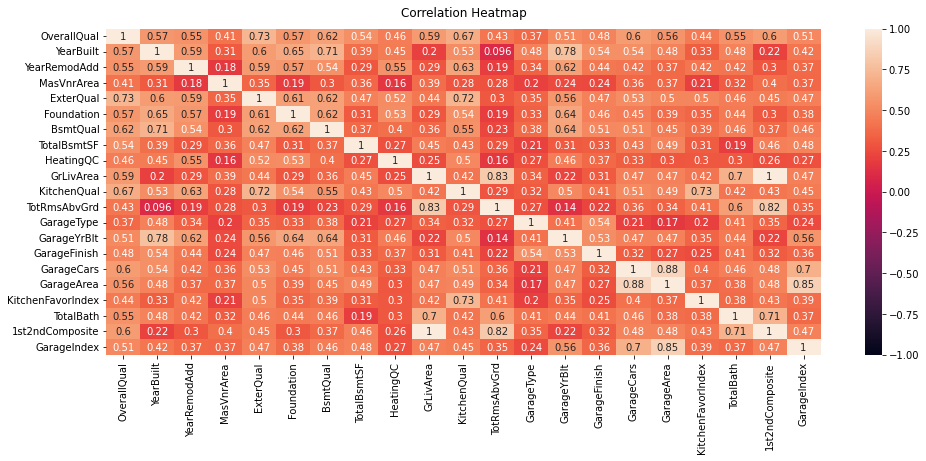

In [40]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


# **Modeling**

I'll use random forest,so no feature scaling is necessary. Also, I'll use ElasticNet because majority of features has at least high correlation(r > 0.5) with another feature. To combine Randomforest and ElasticNet, I used voting regressor.

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn import metrics

en = ElasticNet(max_iter = 1500, random_state=0)
rf = RandomForestRegressor(n_estimators = 100, random_state = 50)
vt = VotingRegressor([('rf', rf), ('en', en)])
vt.fit(train_data, train_target)

train_pred = vt.predict(train_data)
print('Mean Absolute Error:', metrics.mean_absolute_error(train_target, train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(train_target, train_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(train_target, train_pred)))
print('R2:',metrics.r2_score(train_target, train_pred))

prediction = vt.predict(test_data)
submission = pd.DataFrame({
    "Id" : test["Id"],
    "SalePrice" : prediction
})
submission.to_csv('submission_5.csv', index=False)


Mean Absolute Error: 13743.530583297139
Mean Squared Error: 536349705.628956
Root Mean Squared Error: 23159.225065380662
R2: 0.9149567647035293
